In [1]:
import torch
import torch.nn as nn

import numpy as np
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

from tqdm import tqdm
import matplotlib.pyplot as plt

print(torch.cuda.is_available())

device = "cuda" if torch.cuda.is_available() else "cpu"

True


In [2]:
train = datasets.MNIST(root = "data",
                           train = True,
                           download  = True,
                           transform = ToTensor())
test = datasets.MNIST(root = "data",
                           train = False,
                           download  = True,
                           transform = ToTensor())

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.53MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.66MB/s]


In [7]:
X_train, Y_train = train.data, train.targets
X_test, Y_test = test.data, test.targets

In [8]:
labels = list(train.classes)

labels

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

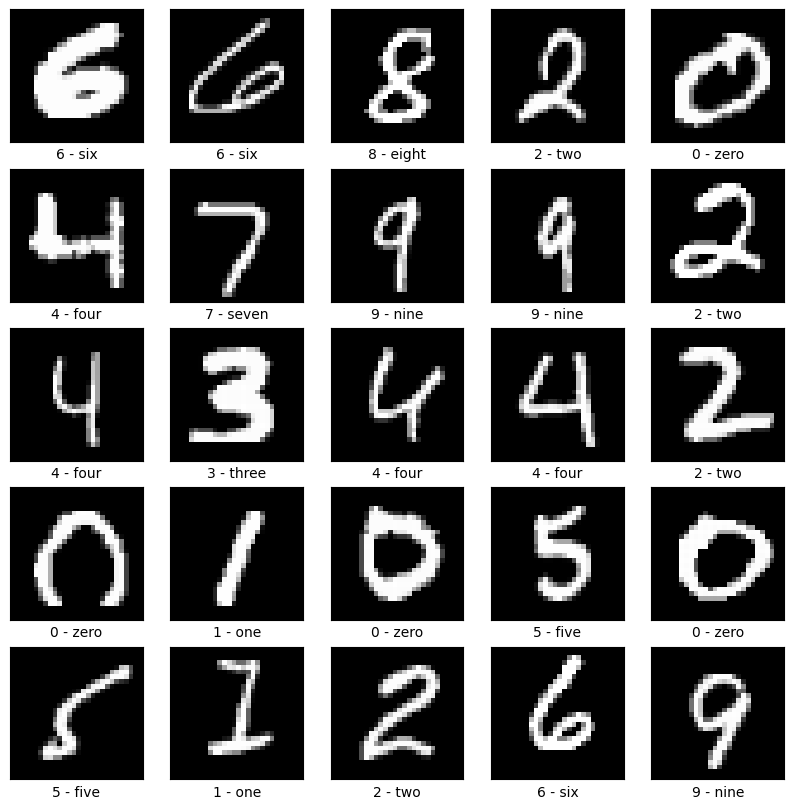

In [9]:
rows = 5
cols = 5

torch.manual_seed(42)
plt.figure(figsize = (10, 10))
for i in range(1, rows*cols+1):
    plt.subplot(5, 5, i)
    indx = torch.randint(0, len(X_train), size=[1]).item()
    plt.imshow(X_train[indx], cmap="gray")
    plt.xlabel(labels[Y_train[indx]])
    plt.xticks([])
    plt.yticks([])
    # plt.axis(False)
plt.show()

In [10]:
train_loader = DataLoader(dataset = train,
                          batch_size = 64,
                          shuffle = True)
test_loader = DataLoader(dataset = test,
                         batch_size= 64,
                         shuffle = False)


In [11]:
train_data, train_label = next(iter(train_loader))

print(f"len(train_loader): {len(train_loader)}")
print(f"type(train_loader): {type(train_loader)}")
print(f"train_data.shape: {train_data.shape}")
print(f"len(train_data): {len(train_data)}")
print(f"train_label.dtype: {train_label.dtype}")

len(train_loader): 938
type(train_loader): <class 'torch.utils.data.dataloader.DataLoader'>
train_data.shape: torch.Size([64, 1, 28, 28])
len(train_data): 64
train_label.dtype: torch.int64


(torch.Size([1, 28, 28]), torch.Size([]))

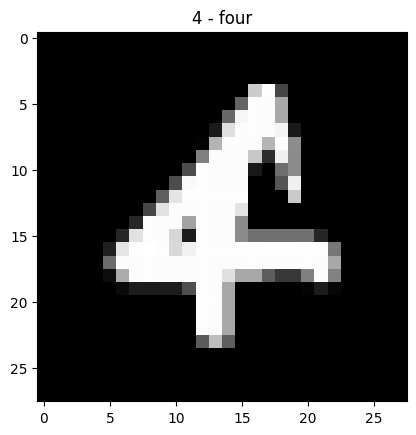

In [12]:
indx = torch.randint(0, len(train_data), size=[1]).item()
plt.imshow(train_data[indx].squeeze(), cmap="gray") # "train_data" belongs to a batch ie., its a batch
plt.title(labels[train_label[indx]]); # "train_label" belongs to a batch ie., its a batch

train_data[indx].shape, train_label[indx].shape

#below is a BAD model

In [ ]:
model = nn.Sequential(
    # block- 1
    nn.Conv2d(in_channels=1,
              out_channels=32,
              kernel_size=3,
              padding=1), nn.ReLU(),

    nn.Conv2d(in_channels=32,
              out_channels=32,
              kernel_size=3,
              padding=1), nn.ReLU(),

    nn.Conv2d(in_channels=32,
              out_channels=32,
              kernel_size=3,
              padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    # block- 2
    nn.Conv2d(in_channels=32,
              out_channels=32,
              kernel_size=3,
              padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),


    nn.Conv2d(in_channels=32,
              out_channels=32,
              kernel_size=3,
              padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),


    # linear layers
    nn.Flatten(),
    nn.Linear(in_features=32*3*3,
              out_features=64), nn.ReLU(),

    nn.Dropout(0.5),
    nn.Linear(in_features=64,
              out_features=len(labels)),
).to(device)

#this is a good model

In [56]:
model = nn.Sequential(
    nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
    nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2),  # 28→14

    nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2),  # 14→7

    nn.Conv2d(32, 32, 3, padding=1), nn.ReLU(),
    nn.MaxPool2d(2),  # 7→3

    nn.Flatten(),
    nn.Linear(32*3*3, 64), nn.ReLU(),  # 288 → why 64? Bottleneck for abstraction
    nn.Dropout(0.5),  # Why 0.5? Prevents overfitting by randomizing ~50% neurons
    nn.Linear(64, 10)  # Logits for 10 classes
).to(device)

In [57]:
l_tr = []
l_ts = []

In [58]:
epochs = 3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in tqdm(range(epochs)):
    train_loss = test_loss = acc = pts = 0
    model.train()

    for btch_no, (x_train, y_train) in enumerate(train_loader):
        optimizer.zero_grad()
        y_train_pred = model(x_train.to(device))
        loss = loss_fn(y_train_pred, y_train.to(device))
        train_loss += loss


        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)


    model.eval()
    with torch.inference_mode():
        for x_test, y_test in test_loader:
            y_test_pred = model(x_test.to(device))
            test_loss += loss_fn(y_test_pred, y_test.to(device))
            acc += torch.sum(torch.argmax(y_test_pred, dim=1).to(device) == y_test.to(device))
            pts += len(y_test)


        test_loss /= len(test_loader)
        acc = (acc/pts) * 100

    l_tr.append(train_loss.detach().cpu())
    l_ts.append(test_loss.detach().cpu())

    print(f"\nEpoch: {epoch} | Train loss: {train_loss: .4f} | Test loss: {test_loss: .4f} | Accuracy:{acc: .2f}\n")

print(f"y_train_pred: {torch.argmax(y_train_pred, dim=1)}")
print(f"y_train: {y_train}")

 33%|███▎      | 1/3 [00:10<00:21, 10.60s/it]


Epoch: 0 | Train loss:  0.3774 | Test loss:  0.0557 | Accuracy: 98.17



 67%|██████▋   | 2/3 [00:21<00:10, 10.59s/it]


Epoch: 1 | Train loss:  0.1226 | Test loss:  0.0362 | Accuracy: 98.81



100%|██████████| 3/3 [00:32<00:00, 10.78s/it]


Epoch: 2 | Train loss:  0.0853 | Test loss:  0.0328 | Accuracy: 98.98

y_train_pred: tensor([5, 1, 4, 1, 8, 3, 7, 0, 1, 5, 3, 9, 8, 0, 4, 8, 3, 3, 6, 9, 3, 8, 4, 1,
        4, 8, 4, 2, 5, 2, 8, 6], device='cuda:0')
y_train: tensor([5, 1, 4, 1, 8, 3, 7, 0, 1, 5, 3, 9, 8, 0, 4, 8, 3, 3, 6, 9, 3, 8, 4, 1,
        4, 8, 4, 2, 5, 1, 8, 6])


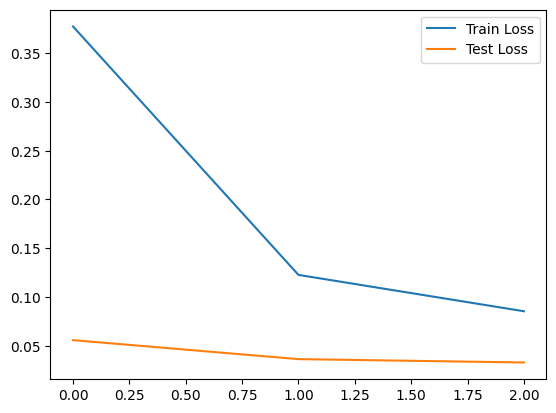

In [64]:
import matplotlib.pyplot as plt

plt.plot(l_tr, label='Train Loss')
plt.plot(l_ts, label='Test Loss')

plt.legend()
plt.show()

In [61]:
x = test[8555]
X = x[0].to(device)
y = x[1]

model.eval()
with torch.inference_mode():
    y_out = model(X.unsqueeze(dim=0))

res = torch.argmax(y_out).item()
res, y

(7, 7)